In [7]:
import warnings
warnings.filterwarnings('ignore')

# Getting Started
Let's walk through an example application of Geometricus in machine learning using a dataset of
human MAP kinases, divided into three classes - JNK, Erk, and p38 kinases. This dataset was generated from the [Kinase-Ligand Interaction Fingerprints and Structures database (KLIFS)](https://klifs.vu-compmedchem.nl/index.php) (Raw table [here](../../example_data/MAPK_KLIFS.tsv)).

In [3]:
import pandas as pnd
from pathlib import Path

data_dir = Path("../../example_data")
mapk_df = pnd.read_csv(data_dir / "MAPK_KLIFS.tsv", sep="\t")

mapk_pdb_to_class = {}
for pdb, chain, class_name in list(zip(mapk_df["PDB"], mapk_df["CHAIN"], mapk_df["CLASS"])):
    mapk_pdb_to_class[(pdb, chain)] = class_name
len(mapk_pdb_to_class)

527

So now we have a list of (PDB ID, chain) pairs, each associated with a class

In [4]:
X_names = list(mapk_pdb_to_class.keys())
class_mapping = {"JNK": 0, "Erk": 1, "p38": 2}
y = [class_mapping[mapk_pdb_to_class[k]] for k in X_names]

## Structural fragmentation
We consider two different ways of dividing a protein with $l$ residues into structural fragments, a $k$-mer-based approach and a radius-based approach. For each structural fragment, four rotation and translation-invariant moments are calculated, termed $O_1, O_2, O_3$, and $O_4$. While the $k$-mer based approach is effective in describing structural fragments that are sequential in nature, such as $\alpha$-helices and loops, the radius-based approach can capture long-range structural contacts as seen in $\beta$-sheets, as well as distinct interaction patterns in space, as found in enzyme active sites.

Below we load a pickle file containing pre-parsed proteins stored as ProDy AtomGroup objects. This can also be done directly from PDB files by replacing the `geometricus.MomentInvariants.from_prody_atomgroup` call by `geometricus.MomentInvariants.from_pdb_file(pdb_file, chain=chain, ...)` or even `from_pdb_id(pdb_id, chain=chain, ...)` to download from RCSB via FTP (note that these two approaches will take longer due to FTP downloading time and file parsing time).

In [8]:
from geometricus import geometricus
import pickle
from time import time

invariants_kmer = {}
invariants_radius = {}
with open(data_dir / "atomgroups.pkl", "rb") as f:
    key_to_atomgroup = pickle.load(f)

start_time = time()
for i, key in enumerate(X_names):
    if i > 0 and i % 50 == 0:
        print(f"{i} proteins in {round(time() - start_time, 2)} seconds")
    invariants_kmer[key] = geometricus.MomentInvariants.from_prody_atomgroup(key, key_to_atomgroup[key], split_type="kmer", split_size=16)
    invariants_radius[key] = geometricus.MomentInvariants.from_prody_atomgroup(key, key_to_atomgroup[key], split_type="radius", split_size=10)

50 proteins in 2.76 seconds
100 proteins in 5.56 seconds
150 proteins in 8.67 seconds
200 proteins in 12.37 seconds
250 proteins in 15.4 seconds
300 proteins in 18.19 seconds
350 proteins in 21.05 seconds
400 proteins in 23.78 seconds
450 proteins in 27.09 seconds
500 proteins in 30.08 seconds


## Generating an Embedding from Structural Fragments
Moment invariants are discretized into shape-mers, using a **resolution** parameter which controls how coarse or fine-grained this discretization is. A count vector of shape-mers is calculated for each protein with each element recording the number of times the corresponding shape-mer appears in that protein. The resolution parameter can be optimized to the task at hand. Generally, more divergent proteins would require a lower resolution while highly similar proteins would need higher resolutions to differentiate them. For the MAP kinases, we use a relatively high resolution of 2.

Depending on the use-case you may want to embed all proteins at once, as demonstrated below, or separate train and test proteins as demonstrated in the Supervised Learning section.

### Embedding for Dimensionality Reduction
Embeddings across all proteins can be used for dimensionality reduction and visualization.

Generated embedding in 2.02 seconds


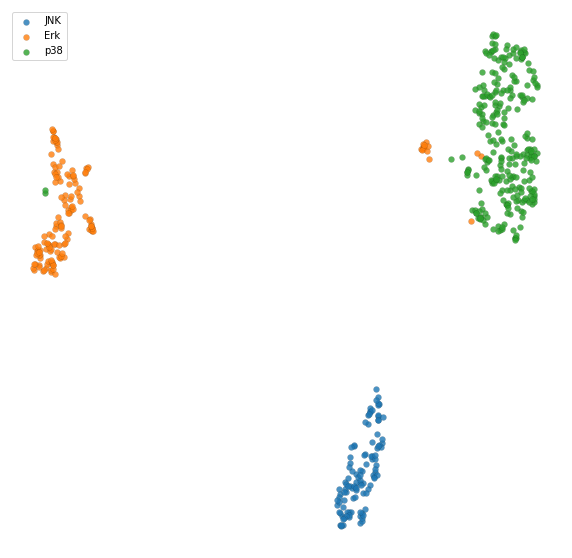

In [11]:
import umap
import numpy as np
import matplotlib.pyplot as plt

start_time = time()
embedder = geometricus.GeometricusEmbedding(invariants_kmer, invariants_radius, resolution=2., protein_keys=X_names)
print(f"Generated embedding in {round(time() - start_time, 2)} seconds")

reducer = umap.UMAP(metric="cosine", n_components=2)
reduced = reducer.fit_transform(embedder.embedding)

class_names = ["JNK", "Erk", "p38"]
colors = ["red", "green", "blue"]
plt.figure(figsize=(10,10))
for i in range(3):
    indices = np.where(np.array(y) == i)[0]
    plt.scatter(reduced[indices, 0],
                reduced[indices, 1],
                label=class_names[i], edgecolor="black", linewidth=0.1, alpha=0.8)
plt.axis("off")
plt.legend();

### Embedding for Supervised Learning
Supervised learning, be it classification or regression, requires some form of training and test set separation.
Below, the shape-mers used for embedding are calculated from the training set and only those shape-mers are counted in the test proteins.

In [14]:
from sklearn.model_selection import train_test_split

X_train_names, X_test_names, y_train, y_test = train_test_split(X_names, y, test_size=0.3)

train_embedder = geometricus.GeometricusEmbedding(invariants_kmer, invariants_radius, resolution=2.,
                                                  protein_keys=X_train_names)

test_embedder = geometricus.GeometricusEmbedding(invariants_kmer, invariants_radius, resolution=2.,
                                                 protein_keys=X_test_names,
                                                 kmer_shape_keys=train_embedder.kmer_shape_keys,
                                                 radius_shape_keys=train_embedder.radius_shape_keys)
X_train, X_test = train_embedder.embedding, test_embedder.embedding

For this simple problem, a decision tree classifier is more than enough to obtain good accuracy.

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

clf = DecisionTreeClassifier(random_state=42, max_depth=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, [0, 1, 2], class_names))

              precision    recall  f1-score   support

         JNK       0.91      0.83      0.87        35
         Erk       0.98      0.98      0.98        44
         p38       0.94      0.97      0.96        80

    accuracy                           0.94       159
   macro avg       0.94      0.93      0.93       159
weighted avg       0.94      0.94      0.94       159



## Finding predictive residues and structural fragments

Since each shape-mer can be mapped back to the residues it describes, it is easy to use Geometricus to determine predictive or functionally relevant residues and structural regions from a trained predictor (or from loadings generated from a method such as PCA). Such insights can be directly be applied to select candidate residues for mutational studies or used in directed evolution techniques to engineer proteins and enzymes with desired properties.

By inspecting the decision tree created above, it becomes clear that some shape-mers are present multiple times across a protein and the number of times differs across classes.

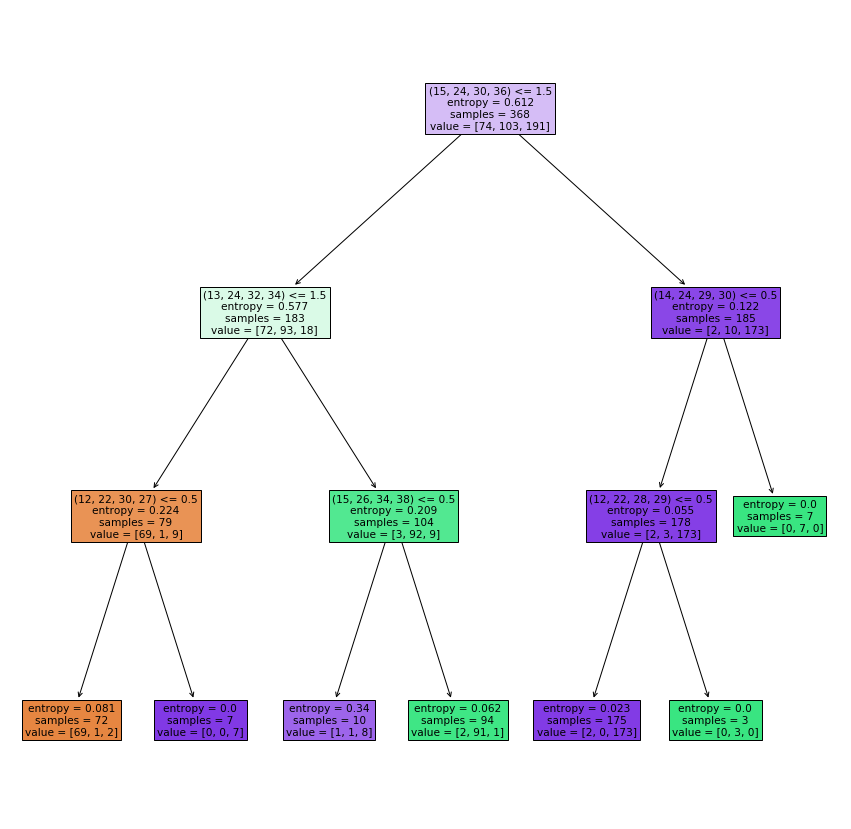

In [17]:
from sklearn.tree import plot_tree
fig, ax = plt.subplots(1, figsize=(15,15))
plot_tree(clf, filled=True, ax=ax, feature_names=train_embedder.kmer_shape_keys + train_embedder.radius_shape_keys);

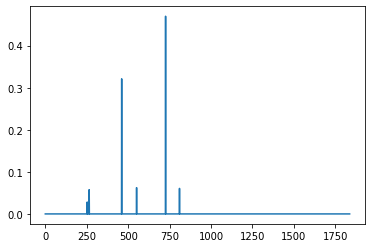

In [18]:
plt.plot(clf.feature_importances_)
predictive_feature_indices = np.argsort(clf.feature_importances_)[::-1][:6]

We can map back to the residues described by a shape-mer using the `map_shapemer_index_to_residues` function which returns a dictionary mapping each protein to the corresponding residue indices of the shape-mer within that protein, if it exists.

In [23]:
shapemer = train_embedder.map_shapemer_index_to_shapemer(predictive_feature_indices[2])
residue_indices_train = train_embedder.map_shapemer_index_to_residues(predictive_feature_indices[2])
print("Shape-mer:", shapemer, "Number of proteins:", len(residue_indices_train))
print("Residue indices per protein:")
for key in residue_indices_train:
    print(key, residue_indices_train[pdb])

Shape-mer: (14, 24, 29, 30) Number of proteins: 12
Residue indices per protein:
('5bvd', 'A') {143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158}
('4myg', 'B') {143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158}
('6hkm', 'A') {143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158}
('6hkn', 'A') {143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158}
('2zoq', 'B') {143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158}
('4zsg', 'A') {143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158}
('5v61', 'A') {143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158}
('5byy', 'A') {143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158}
('4zsj', 'A') {143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158}
('4ic7', 'A') {143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 

These residue indices can then be visualized on a protein structure using molecule visualization software such as PyMol. Comparing the same location in proteins which don't have this shape-mer can also be informative.